Epoch 1/200


c:\Users\asus1\anaconda3\envs\MOSFET_NN_mini\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0784 - mae: 0.1928 - val_loss: 0.0196 - val_mae: 0.1081
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201 - mae: 0.1116 - val_loss: 0.0092 - val_mae: 0.0751
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083 - mae: 0.0690 - val_loss: 0.0047 - val_mae: 0.0473
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - mae: 0.0509 - val_loss: 0.0031 - val_mae: 0.0432
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0391 - val_loss: 0.0012 - val_mae: 0.0226
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mae: 0.0240 - val_loss: 7.9325e-04 - val_mae: 0.0198
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2786e-04 - mae: 0.0207 - val_loss: 7.9459e-04 - val_mae: 0.0192
Epoch 8/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.2211e-04 - mae: 0.0187 - val_loss: 4.7658e-04 - val_mae: 0.0145
Epoch 9/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - los

Model saved as mosfet_model_new.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4621e-06 - mae: 0.0019
Test MAE: 0.001905


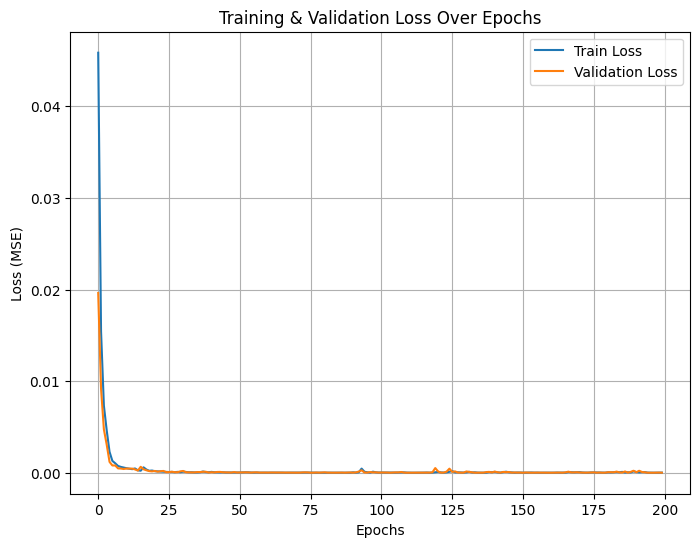

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the dataset
file_path = "Ouput 0-5V Gate -3-0V Step 0.25.txt"
data = np.loadtxt(file_path, usecols=(0, 1))  # Ignore third column

# Extract VDS and ID
VDS = data[:, 0]  # First column is VDS
ID = data[:, 1]  # Second column is ID

# Generate VGS values based on dataset steps
VGS_values = np.arange(-3, 0.25, 0.25)  # VGS from -3V to 0V, step 0.25V
num_VGS = len(VGS_values)
num_points_per_sweep = len(VDS) // num_VGS

# Reshape VDS and ID correctly
VDS_reshaped = VDS[:num_points_per_sweep]  # Take first sweep for VDS reference
ID_reshaped = ID.reshape(num_VGS, num_points_per_sweep)

# Generate (VGS, VDS) pairs as input features
X = np.array([[VGS, vds] for VGS in VGS_values for vds in VDS_reshaped])
y = ID  # Target (ID values)

# Normalize input features and output target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_X.fit(np.array([[min(VGS_values), 0], [max(VGS_values), max(VDS)]]))  # Normalize within dataset range
scaler_y.fit(y.reshape(-1, 1))  # Normalize output (ID)

X_scaled = scaler_X.transform(X)
y_scaled = scaler_y.transform(y.reshape(-1, 1))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Define a new neural network model
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(2,)),  # Two input features: VGS, VDS
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1)  # Single output: ID
])

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Save the trained model
model.save("/mnt/data/mosfet_model_new.h5")
print("Model saved as mosfet_model_new.h5")

# Evaluate model performance
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.6f}")

# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


 1/21 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step

c:\Users\asus1\anaconda3\envs\MOSFET_NN_mini\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test MAE: 1.965761e-05
Test MSE: 5.654039e-10
Test RMSE: 2.377822e-05
Test R² Score: 0.999918


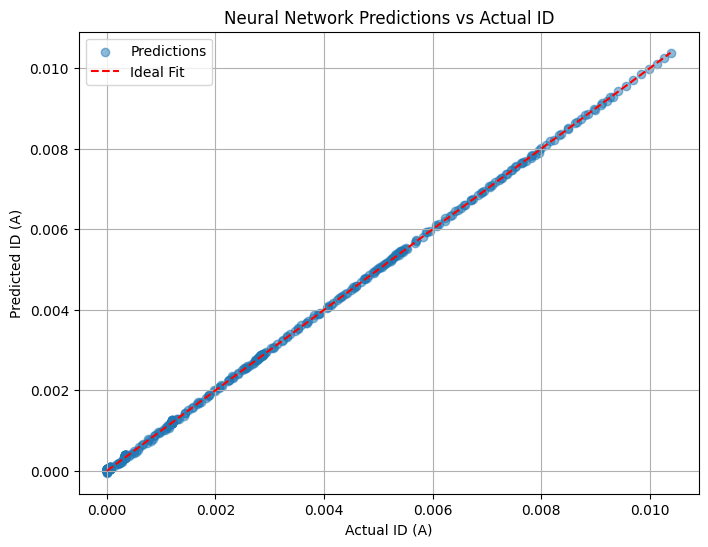

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Load the trained model
model = load_model("bss126ixtsa1.keras")

# Prepare test data again
VGS_values = np.arange(-3, 0.25, 0.25)  # VGS from -3V to 0V, step 0.25V
num_VGS = len(VGS_values)
num_points_per_sweep = len(VDS) // num_VGS
VDS_reshaped = VDS[:num_points_per_sweep]  # First VDS sweep reference

# Generate input data for evaluation
X_test = np.array([[VGS, vds] for VGS in VGS_values for vds in VDS_reshaped])

# Normalize the test data using the same scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_X.fit(np.array([[min(VGS_values), 0], [max(VGS_values), max(VDS)]]))  # Fit using known dataset range
scaler_y.fit(ID.reshape(-1, 1))  # Fit output scaler using ID range

X_test_scaled = scaler_X.transform(X_test)

# Predict ID
ID_pred_scaled = model.predict(X_test_scaled)
ID_pred = scaler_y.inverse_transform(ID_pred_scaled)  # Convert back to real scale

# Extract actual values from dataset
ID_actual = ID.reshape(num_VGS, num_points_per_sweep)
ID_predicted = ID_pred.reshape(num_VGS, num_points_per_sweep)

# Compute performance metrics
mae = mean_absolute_error(ID_actual.flatten(), ID_predicted.flatten())
mse = mean_squared_error(ID_actual.flatten(), ID_predicted.flatten())
rmse = np.sqrt(mse)
r2 = r2_score(ID_actual.flatten(), ID_predicted.flatten())

# Print results
print(f"Test MAE: {mae:.6e}")
print(f"Test MSE: {mse:.6e}")
print(f"Test RMSE: {rmse:.6e}")
print(f"Test R² Score: {r2:.6f}")

# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(ID_actual.flatten(), ID_predicted.flatten(), alpha=0.5, label="Predictions")
plt.plot([min(ID_actual.flatten()), max(ID_actual.flatten())], 
         [min(ID_actual.flatten()), max(ID_actual.flatten())], 'r', linestyle='dashed', label="Ideal Fit")
plt.xlabel("Actual ID (A)")
plt.ylabel("Predicted ID (A)")
plt.title("Neural Network Predictions vs Actual ID")
plt.legend()
plt.grid(True)
plt.show()


In [4]:
model.save("bss126ixtsa1.keras")